
# Loading binance data into trading universe

- Loading CEX data into the TradingStrategy affords you the ability to work with longer historical periods with trading pairs. 
- Using longer historical periods allows you to train your model on more data, which can lead to better results. 
- The only downside is that you will have to wait longer for your backtests to complete the first time you run the notebook. Subsequent runs will be much faster because the data will be cached locally, unless you change the start and end dates, in which case data will be downloaded again. 

In [1]:
import datetime

from tradingstrategy.timebucket import TimeBucket
from tradeexecutor.strategy.cycle import CycleDuration
from tradeexecutor.strategy.strategy_module import StrategyType, TradeRouting, ReserveCurrency


START_AT_DATA = datetime.datetime(2023, 1, 1)
START_AT = datetime.datetime(2023, 2, 1)
END_AT = datetime.datetime(2023, 11, 8)
CANDLE_TIME_BUCKET = TimeBucket.h4

TRADING_STRATEGY_TYPE_ENGINE_VERSION = "0.3"

# What kind of strategy we are running.
# This tells we are going to use
# NOTE: this setting has currently no effect
TRADING_STRATEGY_TYPE = StrategyType.managed_positions

# How our trades are routed.
TRADE_ROUTING = TradeRouting.ignore

# How often the strategy performs the decide_trades cycle.
# We do it for every 4h.
TRADING_STRATEGY_CYCLE = CycleDuration.cycle_4h

# Strategy keeps its cash in USDC
RESERVE_CURRENCY = ReserveCurrency.usdc


# How much % of the available trading capital to put on a single trade
POSITION_SIZE = 0.75

# Start with this amount of USD
INITIAL_DEPOSIT = 50_000

# Candle time granularity we use to trigger stop loss checks
STOP_LOSS_TIME_BUCKET = TimeBucket.h1


# How many candles we load in the decide_trades() function for calculating indicators
LOOKBACK_WINDOW = 20

# Exponential Moving Average (EMA)
# How many candles to smooth out for EMA line
EMA_CANDLE_COUNT = 2  


# How many candles we use to calculate the Relative Strength Index
RSI_LENGTH = 5

# RSI threshold for opening a long position
RSI_THRESHOLD = 25 

# RSI threshold for opening a short position
RSI_THRESHOLD_SHORT = 75 

# START_AT = df.index[0].to_pydatetime() # datetime.datetime(2022, 1, 1)

# END_AT = df.index[-1].to_pydatetime() # datetime.datetime(2022, 1,18)


### FOR LONGS ###

# Stop Loss relative to the mid price during the time when the position is opened
# If the price drops below this level, trigger a stop loss sell
STOP_LOSS_PCT = 0.985

# Take profit percentage for longs
TAKE_PROFIT_PCT = 1.15

# What is the trailing stop loss level, this trails the most recent candle close price
TRAILING_STOP_LOSS_PCT = 0.99

# Activate trailing stop loss when this level is reached
# TRAILING_STOP_LOSS_ACTIVATION_LEVEL=1.01 (In this strategy we don't use a fixed activation level but EMA line crossing is used instead.)


### FOR SHORTING ###

TAKE_PROFIT_SHORT_PCT = 1.15

STOP_LOSS_SHORT_PCT = 0.985

# What is the Trailing Stop Loss level
TRAILING_STOP_LOSS_SHORT_PCT = 0.99

# Activate Trailing Stop Loss when this level is reached
#TRAILING_STOP_LOSS_SHORT_ACTIVATION_LEVEL = 0.99 (In this strategy we don't use a fixed activation level but EMA line crossing is used instead.)

# Leverage ratio for shorting positions. This is due to the mechanism that the shorting protocol needs as we are not able to borrow assets with 1:1 collateral. 
LEVERAGE = 2


## Create Binance Universe

- In the following code block, we show how to create a TradingStrategyUniverse using Binance data.
- This includes downloading candlestick prices and lending rates from Binance. 
- Note that, under the hood, we add additional columns to the Binance OHLCV data to make it compatible with our framework

### Caching

- The data is then cached locally so that you don't have to redownload it every time you run the notebook.
- If you want to force a redownload instead of using cached data, you can set `force_download=True`.

### Data

- The candlestick data contains the usual OHLCV data
- If your startegy utilizes shorting, you will want to include lending data by setting `include_lending=True`. The Binance endpoint only provides one data point per day per asset, so anything more granular than that will have to be upsampled (we use forward filling).

### Date range

- You can specify the date range for which you want to download data by setting `start_date` and `end_date`.
- If you don't specify these, the default is to download data from the earliest date available to the latest date available.

### Multipair

- You can also specify a list of pairs to download data for. In this case, you should specify the `reserve_pair_ticker` argument, which is the pair that will be used to reserve capital for the strategy. Otherwise, it defaults to the first pair in the list.


## Create TradingStrategyUniverse

Finally, we create our TradingStrategyUniverse, which is a combination of our TradingStrategy and LendingCandleUniverse.

In [2]:
from tradeexecutor.utils.binance import create_binance_universe

universe = create_binance_universe(
    ["ETHUSDT"],
    CANDLE_TIME_BUCKET,
    STOP_LOSS_TIME_BUCKET,
    START_AT_DATA,
    END_AT,
    include_lending=True
)

print(f"We loaded {universe.universe.candles.get_candle_count():,} candles.")

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

We loaded 1,873 candles.


## Using the universe in a strategy

In [3]:
from typing import List, Dict

from pandas_ta.overlap import ema
from pandas_ta.momentum import rsi
import pandas as pd

from tradeexecutor.strategy.trading_strategy_universe import TradingStrategyUniverse
from tradeexecutor.state.visualisation import PlotKind, PlotShape
from tradeexecutor.state.trade import TradeExecution
from tradeexecutor.strategy.pricing_model import PricingModel
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager
from tradeexecutor.state.state import State
from tradeexecutor.strategy.pandas_trader.position_manager import PositionManager


def decide_trades(
        timestamp: pd.Timestamp,
        strategy_universe: TradingStrategyUniverse,
        state: State,
        pricing_model: PricingModel,
        cycle_debug_data: Dict) -> List[TradeExecution]:
  
    universe = strategy_universe.universe

    # We have only a single trading pair for this strategy.
    pair = universe.pairs.get_single()

    # How much cash we have in a hand
    cash = state.portfolio.get_current_cash()

    # Get OHLCV candles for our trading pair as Pandas Dataframe.
    # We could have candles for multiple trading pairs in a different strategy,
    # but this strategy only operates on single pair candle.
    # We also limit our sample size to N latest candles to speed up calculations.
    candles: pd.DataFrame = universe.candles.get_single_pair_data(timestamp, sample_count=LOOKBACK_WINDOW, raise_on_not_enough_data=False)

    # We have data for open, high, close, etc.
    # We only operate using candle close values in this strategy.
    close_prices = candles["close"]

    # Calculate exponential moving from candle close prices
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/overlap/help/pandas_ta.overlap.ema.html#ema
    ema_series = ema(close_prices, length=EMA_CANDLE_COUNT)
    
    # Calculate RSI from candle close prices
    # https://tradingstrategy.ai/docs/programming/api/technical-analysis/momentum/help/pandas_ta.momentum.rsi.html#rsi
    rsi_series = rsi(close_prices, length=RSI_LENGTH)

    trades = []

    if ema_series is None or rsi_series is None:
        return trades
 
    ema_latest = ema_series.iloc[-1]      # Let's take the latest EMA value from the series
    price_latest = close_prices.iloc[-1]  # Let's take the latest close price value from the series
    current_rsi = rsi_series.iloc[-1]
    
    

    # Create a position manager helper class that allows us easily to create
    # opening/closing trades for different positions
    position_manager = PositionManager(timestamp, strategy_universe, state, pricing_model)

    

    
    ### LONGING ###
    
    stoploss_price_long = None    # We use this to track Stop Loss price for Long positions and draw it to the price chart
    
    if not position_manager.is_any_long_position_open():
        if price_latest < ema_latest and current_rsi < RSI_THRESHOLD and close_prices.iloc[-2] > ema_series.iloc[-2]:
            amount = cash * POSITION_SIZE
            new_trades = position_manager.open_1x_long(pair, amount, stop_loss_pct=STOP_LOSS_PCT, take_profit_pct=TAKE_PROFIT_PCT)
            trades.extend(new_trades)
            stoploss_price_long = position_manager.get_current_long_position().stop_loss
            
    else:
        current_position = position_manager.get_current_long_position()
        # LONGING: We activate trailing stop loss when the price closes above the EMA line.

        if price_latest >= ema_latest:
            # adjust trailing stop loss level for the open long position
            # Stop loss is the only way we sell in this set up, unless TAKE_PROFIT_PCT level has been reached

            current_position.trailing_stop_loss_pct = TRAILING_STOP_LOSS_PCT
            stoploss_price_long = position_manager.get_current_long_position().stop_loss
            if position_manager.get_current_long_position().stop_loss <= float(price_latest * TRAILING_STOP_LOSS_PCT):   # Move the trailing stop loss level only of the new value is higher
                current_position.stop_loss = float(price_latest * TRAILING_STOP_LOSS_PCT)
                stoploss_price_long = position_manager.get_current_long_position().stop_loss

            
    ### SHORTING ###
    
    stoploss_price_short = None   # We use this to track Stop Loss price for Short positions and draw it to the price chart
    
    if not position_manager.is_any_short_position_open():
        # No open positions, decide if open a position in this cycle.
        # We open short if the latest candle has upper wick above BB upper line and close under this line
        
        if price_latest > ema_latest and current_rsi > RSI_THRESHOLD_SHORT and close_prices.iloc[-2] < ema_series.iloc[-2]:
            amount = cash * POSITION_SIZE
            new_trades = position_manager.open_short(pair, amount, leverage=LEVERAGE, stop_loss_pct=STOP_LOSS_SHORT_PCT, take_profit_pct=TAKE_PROFIT_SHORT_PCT)
            trades.extend(new_trades)
        
            stoploss_price_short = position_manager.get_current_short_position().stop_loss

            
    else:
        current_position = position_manager.get_current_short_position()
        # SHORTING: We activate trailing stop loss when the price closes below the EMA line.

        if price_latest <= ema_latest:             
            # adjust trailing stop loss level for the open short position
            # Stop loss is the only way we sell in this set up, unless TAKE_PROFIT_SHORT_PCT level has been reached
            current_position.trailing_stop_loss_pct = TRAILING_STOP_LOSS_SHORT_PCT
            stoploss_price_short = position_manager.get_current_short_position().stop_loss
            if position_manager.get_current_short_position().stop_loss >= float(price_latest * TRAILING_STOP_LOSS_SHORT_PCT):   # Move the trailing stop loss level only of the new value is lower
                current_position.stop_loss = float(price_latest * TRAILING_STOP_LOSS_SHORT_PCT)
                stoploss_price_short = position_manager.get_current_short_position().stop_loss

    any_open_positions = position_manager.is_any_open()
    awe = 100 if any_open_positions else 0

    # Visualise our technical indicators
    visualisation = state.visualisation
    visualisation.plot_indicator(timestamp, "EMA", PlotKind.technical_indicator_on_price, ema_series.iloc[-1], colour="black")
    visualisation.plot_indicator(timestamp, "RSI", PlotKind.technical_indicator_detached, current_rsi)
    visualisation.plot_indicator(timestamp, "RSI Threshold", PlotKind.technical_indicator_overlay_on_detached, RSI_THRESHOLD, detached_overlay_name="RSI")
    #visualisation.plot_indicator(timestamp, "RSI Threshold", PlotKind.technical_indicator_detached, RSI_THRESHOLD_SHORT, detached_overlay_name="RSI")

    visualisation.plot_indicator(timestamp, "Stop Loss long", PlotKind.technical_indicator_on_price, stoploss_price_long, colour="purple", plot_shape=PlotShape.horizontal_vertical)
    visualisation.plot_indicator(timestamp, "Stop Loss short", PlotKind.technical_indicator_on_price, stoploss_price_short, colour="blue", plot_shape=PlotShape.horizontal_vertical)

    return trades

## Create the client

Create the trading strategy client to run the backtest

In [4]:
from tradingstrategy.client import Client

client = Client.create_jupyter_client()

Started Trading Strategy in Jupyter notebook environment, configuration is stored in /root/.tradingstrategy


## Run the backtest

In [5]:
import logging

from tradeexecutor.backtest.backtest_runner import run_backtest_inline

state, universe, debug_dump = run_backtest_inline(
    name="ETH/USDC fast and slow EMA example",
    start_at=START_AT,
    end_at=END_AT,
    client=client,
    cycle_duration=TRADING_STRATEGY_CYCLE,
    decide_trades=decide_trades,
    universe=universe,
    # create_trading_universe=create_single_pair_trading_universe,
    initial_deposit=INITIAL_DEPOSIT,
    reserve_currency=RESERVE_CURRENCY,
    trade_routing=TRADE_ROUTING,
    log_level=logging.WARNING,
    engine_version=TRADING_STRATEGY_TYPE_ENGINE_VERSION,
)

trade_count = len(list(state.portfolio.get_all_trades()))
print(f"Backtesting completed, backtested strategy made {trade_count} trades")

  0%|          | 0/24192000 [00:00<?, ?it/s]

Backtesting completed, backtested strategy made 78 trades


In [6]:
print(f"Positions taken: {len(list(state.portfolio.get_all_positions()))}")
print(f"Trades made: {len(list(state.portfolio.get_all_trades()))}")

Positions taken: 39
Trades made: 78


## Visualise results

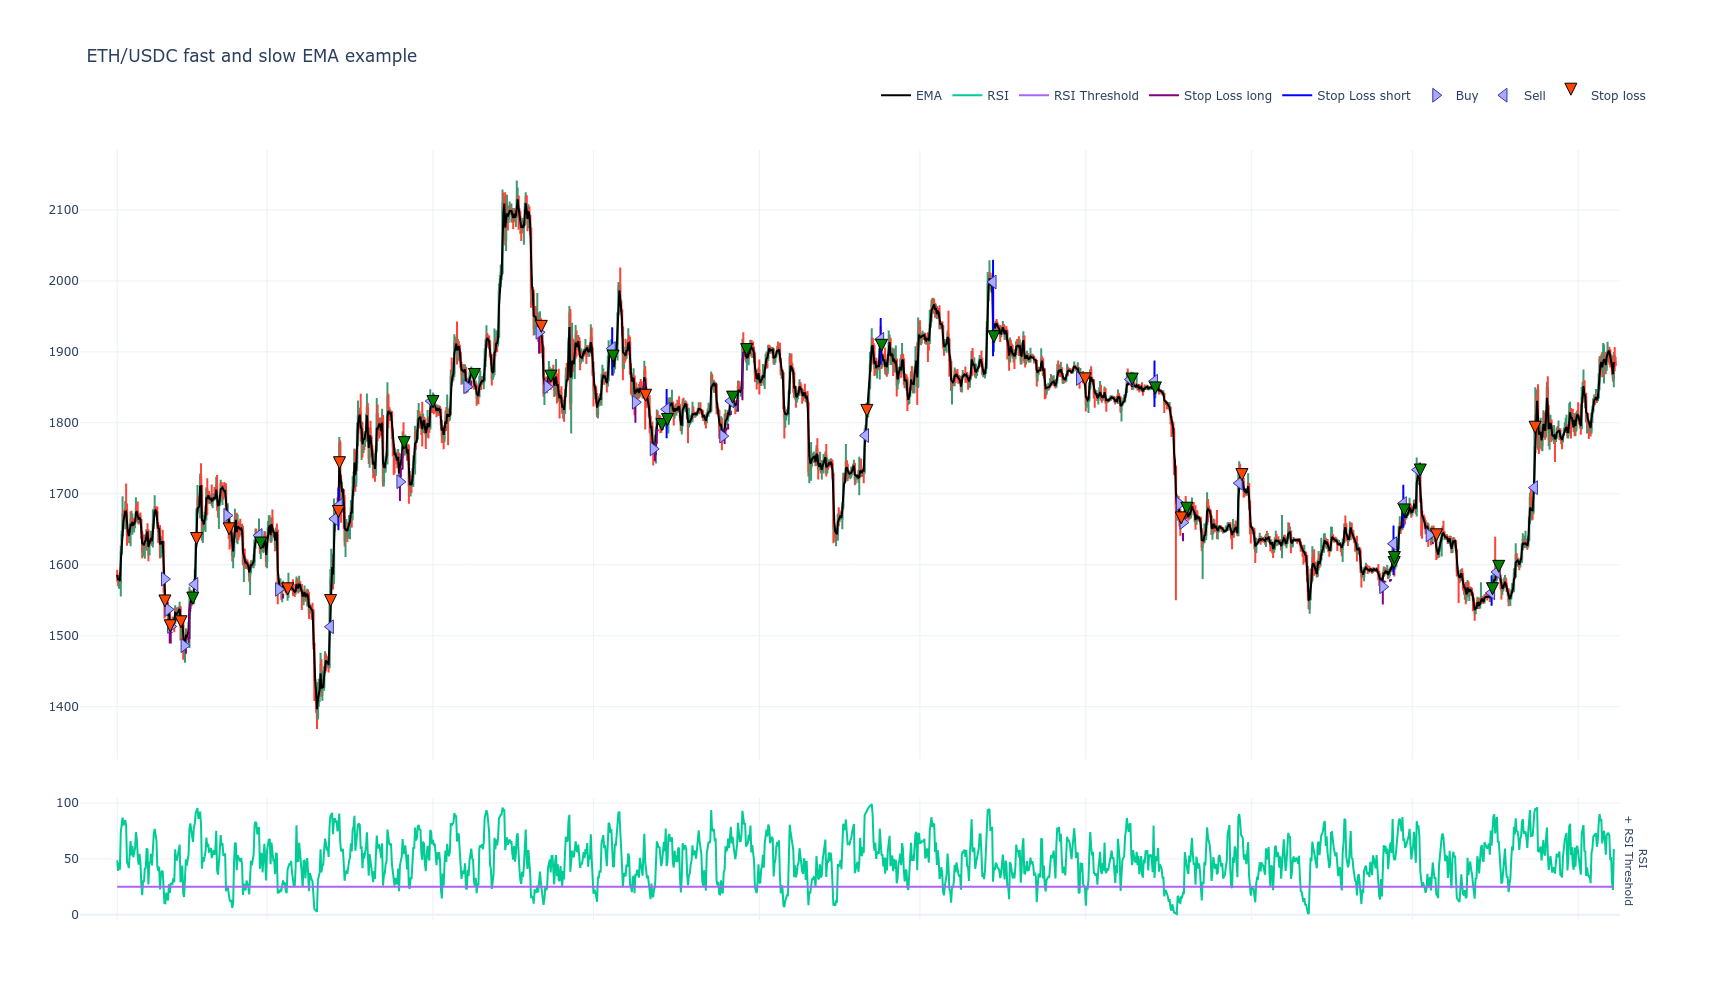

In [7]:
from tradeexecutor.visual.single_pair import visualise_single_pair
from tradingstrategy.charting.candle_chart import VolumeBarMode

figure = visualise_single_pair(
    state,
    universe.universe.candles,
    start_at=START_AT,
    end_at=END_AT,
    volume_bar_mode=VolumeBarMode.hidden,
    volume_axis_name="Volume (USD)",
    height = 1000,
    hover_text=True,
)

figure.show()

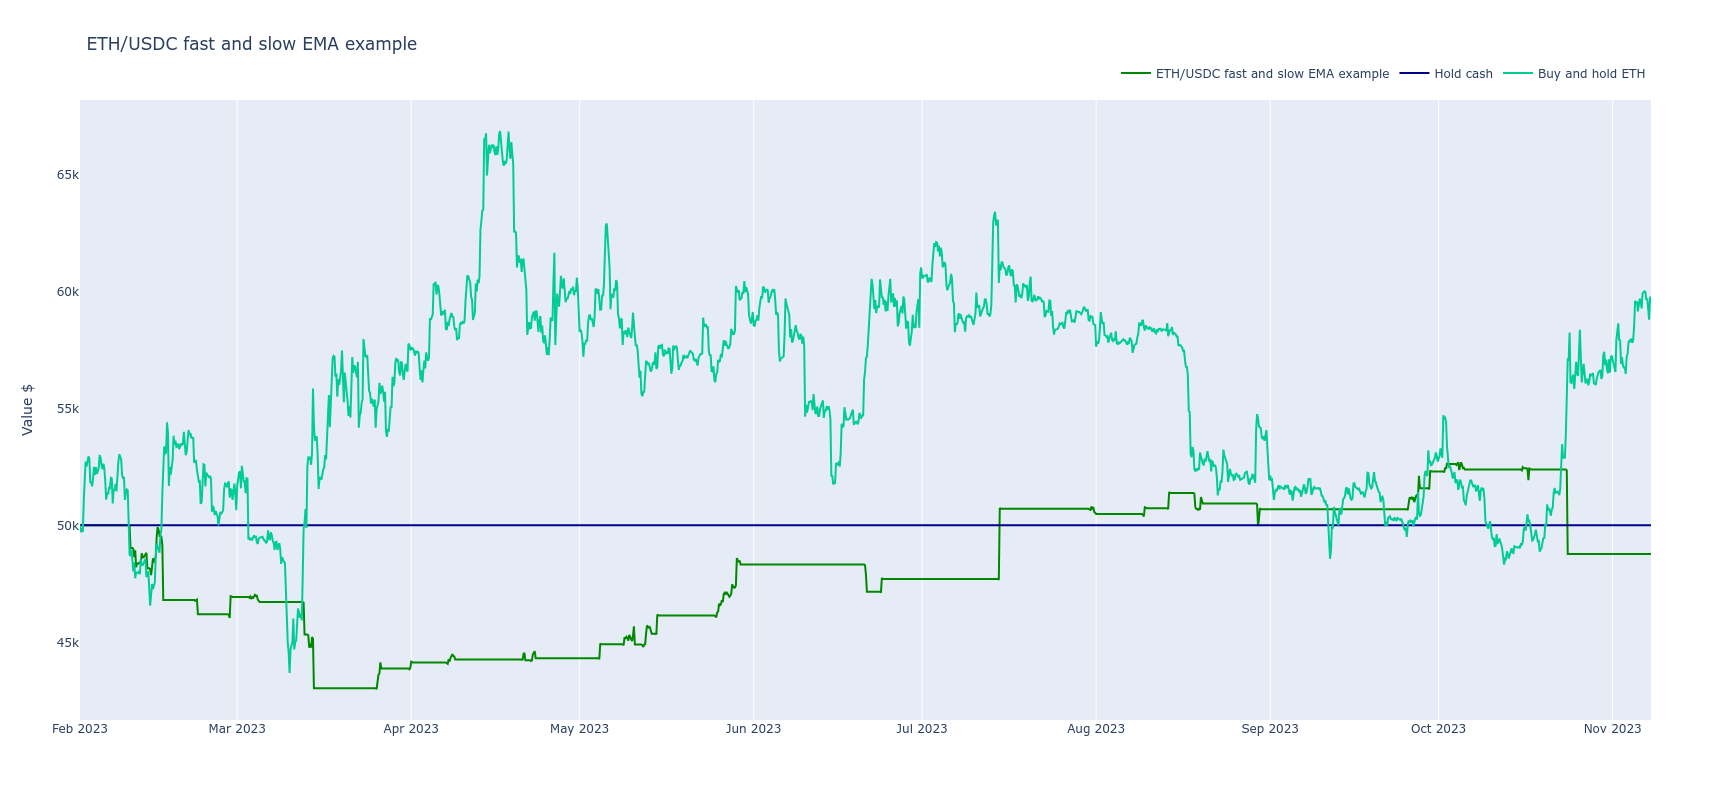

In [8]:
from tradeexecutor.visual.benchmark import visualise_benchmark

traded_pair = universe.universe.pairs.get_single()

fig = visualise_benchmark(
    state.name,
    portfolio_statistics=state.stats.portfolio,
    all_cash=state.portfolio.get_initial_deposit(),
    buy_and_hold_asset_name=traded_pair.base_token_symbol,
    buy_and_hold_price_series=universe.universe.candles.get_single_pair_data()["close"],
    start_at=START_AT,
    end_at=END_AT,
    height=800
)

fig.show()

## Statistics for longing and shorting

In [9]:
from tradeexecutor.analysis.trade_analyser import build_trade_analysis

analysis = build_trade_analysis(state.portfolio)

In [10]:
from IPython.core.display_functions import display

summary = analysis.calculate_all_summary_stats_by_side(state=state, time_bucket=CANDLE_TIME_BUCKET)

with pd.option_context("display.max_row", None):
    display(summary)

In [11]:
from IPython.core.display_functions import display

summary = analysis.calculate_summary_statistics(state=state, time_bucket=CANDLE_TIME_BUCKET)

# with pd.option_context("display.max_row", None):
#      display(summary.to_dataframe())

summary.display()